<a href="https://colab.research.google.com/github/omidmno2/stockMarketPrediction_DL/blob/main/AAPL_1hr_CNN_LSTM_with_standard_scaler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 6.2 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=7786382a66e6e2b19d035aa71633789719860893d5e4b214c20f61fea119cb36
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [4]:
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

In [5]:
import yfinance as yf
one_hr_data = yf.download(tickers='AAPL', period = '730d', interval = '1h')
one_hr_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
2018-11-30 09:30:00-05:00,45.075001,45.077499,44.479752,44.572498,44.572498,0
2018-11-30 10:30:00-05:00,44.577675,44.695000,44.445000,44.480000,44.480000,3550111
2018-11-30 11:30:00-05:00,44.487499,44.602501,44.402500,44.491974,44.491974,3085512
2018-11-30 12:30:00-05:00,44.490002,44.542477,44.334999,44.415001,44.415001,2263433
2018-11-30 13:30:00-05:00,44.419350,44.607498,44.365002,44.435825,44.435825,3008646
...,...,...,...,...,...,...
2021-10-22 14:30:00-04:00,149.429993,149.671600,148.869995,148.945007,148.945007,5696114
2021-10-22 15:30:00-04:00,148.940002,149.179993,148.639999,148.690002,148.690002,5688679
2021-10-25 09:30:00-04:00,148.679993,149.369995,147.621094,147.914993,147.914993,13718616
2021-10-25 10:30:00-04:00,147.910004,148.109894,147.740097,148.039993,148.039993,3538391


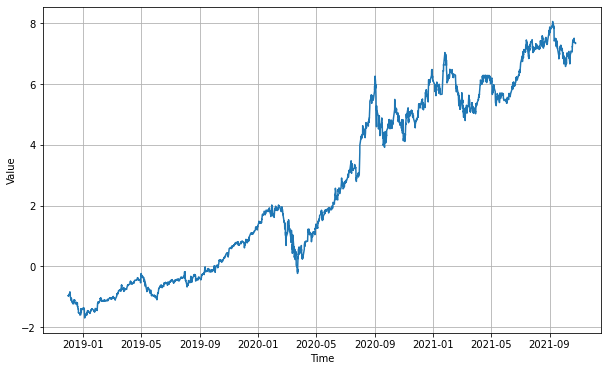

In [6]:
from sklearn.preprocessing import StandardScaler

series = one_hr_data['Close'].values.reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

series = np.array(series)
time = np.array(one_hr_data.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
split_time = 4000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(4000,)
Epoch 1/100
16/16 [==============================] - 35s 61ms/step - loss: 5.3629 - mae: 5.8389
Epoch 2/100
16/16 [==============================] - 1s 63ms/step - loss: 5.2204 - mae: 5.6990
Epoch 3/100
16/16 [==============================] - 1s 63ms/step - loss: 5.0393 - mae: 5.5214
Epoch 4/100
16/16 [==============================] - 1s 65ms/step - loss: 4.8458 - mae: 5.3296
Epoch 5/100
16/16 [==============================] - 1s 63ms/step - loss: 4.6476 - mae: 5.1313
Epoch 6/100
16/16 [==============================] - 1s 65ms/step - loss: 4.4432 - mae: 4.9259
Epoch 7/100
16/16 [==============================] - 1s 64ms/step - loss: 4.2347 - mae: 4.7161
Epoch 8/100
16/16 [==============================] - 1s 64ms/step - loss: 4.0277 - mae: 4.5083
Epoch 9/100
16/16 [==============================] - 1s 64ms/step - loss: 3.8176 - mae: 4.2971
Epoch 10/100
16/16 [======================

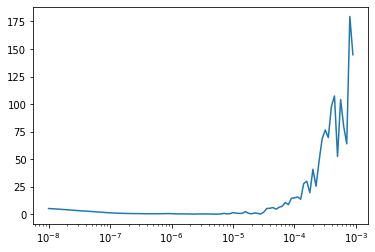

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=3e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
40/40 [==============================] - 5s 37ms/step - loss: 1.3270 - mae: 1.7604
Epoch 2/150
40/40 [==============================] - 2s 37ms/step - loss: 2.7939 - mae: 3.2437
Epoch 3/150
40/40 [==============================] - 2s 37ms/step - loss: 4.1092 - mae: 4.6056
Epoch 4/150
40/40 [==============================] - 2s 37ms/step - loss: 4.0202 - mae: 4.5136
Epoch 5/150
40/40 [==============================] - 2s 37ms/step - loss: 2.6417 - mae: 3.1195
Epoch 6/150
40/40 [==============================] - 2s 36ms/step - loss: 3.2041 - mae: 3.6778
Epoch 7/150
40/40 [==============================] - 2s 37ms/step - loss: 2.1190 - mae: 2.6080
Epoch 8/150
40/40 [==============================] - 2s 36ms/step - loss: 2.5842 - mae: 3.0414
Epoch 9/150
40/40 [==============================] - 2s 37ms/step - loss: 1.2791 - mae: 1.7094
Epoch 10/150
40/40 [==============================] - 2s 36ms/step - loss: 1.9108 - mae: 2.3974
Epoch 11/150
40/40 [=============================

In [13]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

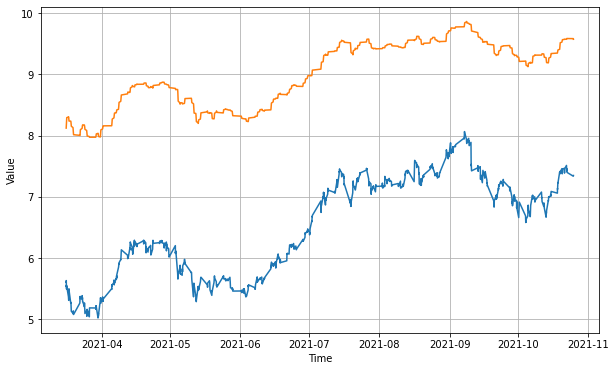

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [85]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

2.9076653

In [86]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[ 1.8615248   1.7424954   1.6254276   1.5828438   1.5096529   1.2573298
  1.0262463   1.0331986   0.9170458   0.85491836  0.80024785  0.74824077
  0.8002536   0.89955854  0.9167741   0.95568514  0.98705095  1.0694323
  1.0905286   1.0947118   1.0764086   1.0222079   0.9827543   1.014646
  1.0832359   1.1294173   1.2006402   1.2447231   1.2763056   1.3129449
  1.3696734   1.4225957   1.4376614   1.451085    1.3964739   1.3505807
  1.3507994   1.333136    1.3088098   1.297214    1.3350991   1.4011832
  1.4018337   1.3683496   1.343937    1.3724538   1.4264511   1.472338
  1.4976425   1.5262094   1.5580019   1.5960584   1.7178046   1.8205835
  1.8426906   1.9088467   1.9203616   1.9193264   1.9374311   1.9852957
  2.096164    2.16221     2.1217124   2.0119026   1.9000998   1.8937011
  1.944038    2.0328455   2.0425076   2.028165    2.0922403   2.127544
  2.1277385   2.0989702   2.0168924   1.9688941   1.9599887   1.8887556
  1.8464599   1.8512491   1.880507    1.9644139   2.0015728   2.03